In [ ]:
from tqdm import tqdm
from IPython.display import clear_output

import pandas as pd
from google.colab import files
import zipfile
import os
from os import listdir
import cv2
import json
import random

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
%matplotlib inline
from PIL import Image

from skimage.io import imread
import numpy as np
from pathlib import Path

Загружаем датасет с кагла.

In [ ]:
!pip install kaggle==1.5.6

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/synthetic-word-ocr -p /content/

with zipfile.ZipFile('/content/synthetic-word-ocr.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72858 sha256=0d1778a59611c2ce15bf5d0abf87409edd9f4e1acca7b8a7352687a2ebe2a33b
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json
100% 3.92G/3.93G [01:30<00:00, 87.1MB/s]
100% 3.93G/3.93G [01:30<00:00, 46.7MB/s]


In [ ]:
dir_kaggle = Path('/content/kaggle/train/images')

!mkdir '/content/kaggle/train/labeled_images'
dir_img = Path('/content/kaggle/train/labeled_images')

dir_test = Path('/content/test')

In [ ]:
with open('/content/kaggle/annotation.json', 'r') as f:
    annot_data = json.load(f)

In [ ]:
image_df = pd.DataFrame(annot_data['images'])
annot_df = pd.DataFrame(annot_data['annotations'])
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()

old_shape = full_df.groupby('image_id').first().reset_index().shape
old_shape

(280741, 11)

Удаляем изображения тестовой выборки из датасета.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/Цифровой прорыв 22/test_dataset_test.zip', 'r') as zip_ref:
    zip_ref.extractall(dir_test)

In [ ]:
names = os.listdir(dir_test)
len(names)

900

In [ ]:
old_len = len(os.listdir(dir_kaggle))

for name in names:
    os.remove(os.path.join(dir_kaggle, name))

new_len = len(os.listdir(dir_kaggle))

In [ ]:
full_df = full_df[~full_df.file_name.isin(names)]

new_shape = full_df.groupby('image_id').first().reset_index().shape

In [ ]:
old_len - new_len

900

In [ ]:
old_shape[0] - new_shape[0]

900

Удалено 900 файлов.

In [ ]:
cmap = plt.cm.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

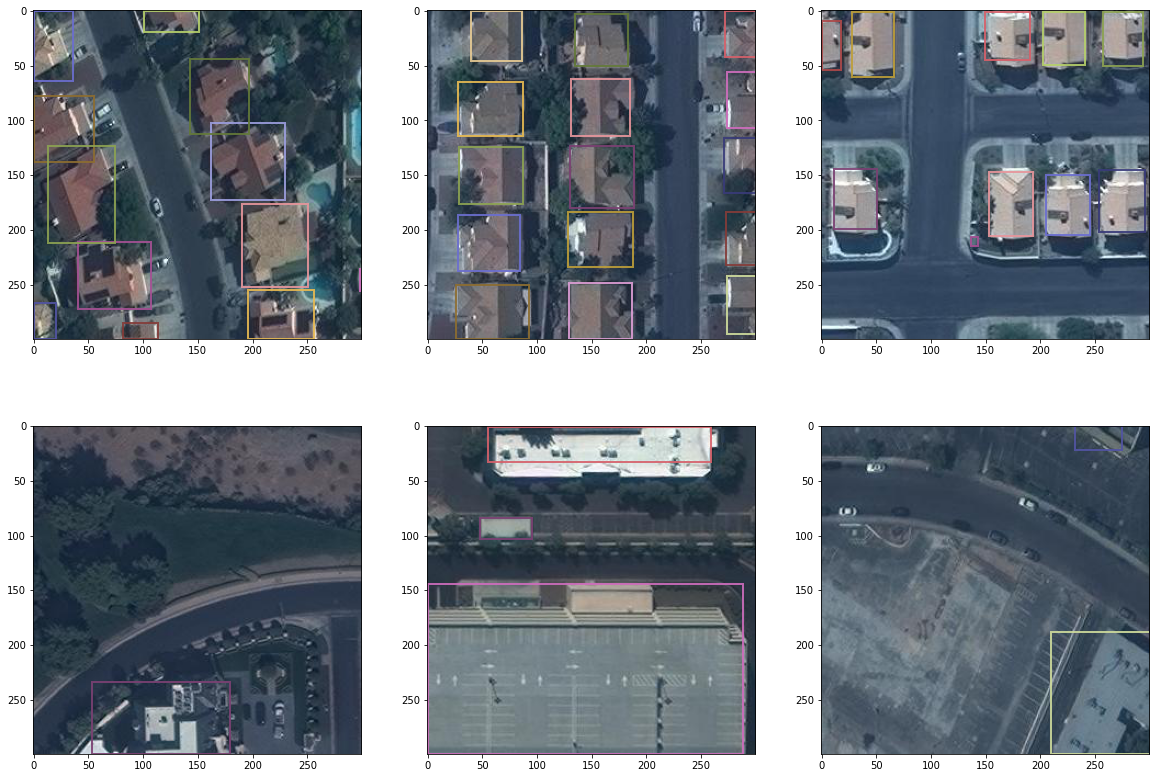

In [ ]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 14))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(dir_kaggle, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)

    label_nums = len(c_df)
    bbox_color = random.sample(colors, label_nums)
    i = 0
    for _, c_row in c_df.iterrows():
        # В c_row['bbox'] какая-то фигня.Найдем максимумы и минимумы из сегментации.
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        xy_matrix = xy_vec.transpose()

        xMin = np.amin(xy_matrix[0])
        xMax = np.amax(xy_matrix[0])

        yMin = np.amin(xy_matrix[1])
        yMax = np.amax(xy_matrix[1])

        w = xMax - xMin
        h = yMax - yMin

        cls_color = bbox_color[i]

        c_ax.add_patch(Rectangle((xMin, yMin), w, h, 0, linewidth=2, edgecolor = cls_color, alpha = 0.9, facecolor='none'))

        i += 1

plt.show()

Разметка изображений на основе данных из датафрейма.

In [ ]:
def rows_to_bbox(in_df, img_width, img_height):
    bboxes = []
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        xy_matrix = xy_vec.transpose()

        xMin = round(np.amin(xy_matrix[0]), 2)
        xMax = round(np.amax(xy_matrix[0]), 2)

        yMin = round(np.amin(xy_matrix[1]), 2)
        yMax = round(np.amax(xy_matrix[1]), 2)

        # Встречаются bboxы 0 высоты или ширины.
        if xMin == xMax:
            if xMax < 150:
              xMax = xMax + 0.01
            else:
              xMax = xMax - 0.01

        if yMin == yMax:
            if yMax < 150:
              yMax = yMax + 0.01
            else:
              yMax = yMax - 0.01
        
        # Была ошибка, что bbox вылазит за рамки изображения
        if xMin > 300:
            continue
        if yMin > 300:
            continue
        if xMax > 300:
            continue
        if yMax > 300:
            continue

        bbox = f'0 {round((xMax + xMin) / (2 * img_width), 4)} {round((yMax + yMin) / (2 * img_height), 4)} {round((xMax - xMin) / img_width, 4)} {round((yMax - yMin) / img_height, 4)}'

        bboxes.append(bbox)

    return bboxes

In [ ]:
group_df = full_df.groupby('image_id').first().reset_index()

ids = list(group_df.file_name)
images_fps = [os.path.join(dir_img, image_id) for image_id in ids]

In [ ]:
i = 0
for index, item in tqdm(group_df.iterrows()):
    imf_df = full_df.query('file_name == "' + item.file_name + '"')
    bboxes = rows_to_bbox(imf_df, 300, 300)

    # print(index)
    # print(item.file_name)
    # print(bboxes)

    # print(os.path.join(dir_lbs, os.path.splitext(item.file_name)[0]+'.txt'))

    from_file = os.path.join(dir_kaggle, item.file_name)
    to_file = os.path.join(dir_img, item.file_name)
    os.popen(f'cp {from_file} {to_file}')

    with open(os.path.join(dir_img, os.path.splitext(item.file_name)[0]+'.txt'), "w") as file:
        print(*bboxes, file=file, sep="\n")

    if i >= 21000:
        break
    i += 1

21000it [2:18:49,  2.52it/s]


In [ ]:
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/Цифровой прорыв 22/kaggle_dataset_21000.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir(dir_img, zipf)

Разметить все 280 тыс изображений не удалось, потому что нужно очень много времени. Также много времени уйдет на обучение. Сохраним, то что разметилось и затем будем использовать этот архив.